# 1. **Cross-Correlation**
Each output unit is a linear function of a localized subset of input units.
Cross-correlation is an operation used to measure the **similarity** between a filter/kernel and a region of an image (or feature map). It's defined as:

$
(f \star g)[i, j] = \sum_m \sum_n f[i + m, j + n] \cdot g[m, n]
$

- You slide the kernel `g` over the input `f`.
- You **do not flip** the kernel.
- Multiply corresponding elements and sum them.

This is the **actual operation** used in deep learning frameworks like PyTorch and TensorFlow when we say "convolution".

---

# 2. **Convolution**

Mathematically, convolution involves **flipping the kernel** both horizontally and vertically before applying it:

$
(f * g)[i, j] = \sum_m \sum_n f[i + m, j + n] \cdot g[-m, -n]
$

- Used in signal processing.
- Has properties like **commutativity** and **associativity** that are useful in theory.

---


**Why DL Libraries Use Cross-Correlation?**

Because in learning, the **filter is learned**, and flipping it doesn’t add value—so it’s simpler to define the operation as cross-correlation.


In [3]:
import torch
import torch.nn.functional as F

# Input tensor (1 image, 1 channel, 5x5)
input = torch.tensor([[[[1., 2., 3., 0., 1.],
                        [0., 1., 2., 3., 1.],
                        [1., 0., 1., 2., 2.],
                        [2., 1., 0., 1., 3.],
                        [1., 2., 3., 0., 1.]]]])
print(input.shape)
# Kernel (1 filter, 1 channel, 3x3)
kernel = torch.tensor([[[[0., 1., 0.],
                         [1., -4., 1.],
                         [0., 1., 0.]]]])

# Apply cross-correlation (no flip), In CNNs, we don't usually flip the kernel because weights are learned.
cross_corr = F.conv2d(input, kernel)
print("Cross-correlation result:\n", cross_corr)

# Flip kernel to do convolution
flipped_kernel = torch.flip(kernel, [2, 3])  # Flip height and width
conv_result = F.conv2d(input, flipped_kernel)
print("\nConvolution result:\n", conv_result)

torch.Size([1, 1, 5, 5])
Cross-correlation result:
 tensor([[[[ 0.,  0., -7.],
          [ 4.,  0., -1.],
          [ 0.,  6.,  1.]]]])

Convolution result:
 tensor([[[[ 0.,  0., -7.],
          [ 4.,  0., -1.],
          [ 0.,  6.,  1.]]]])


---
# **3. Most Common Types of Convolution in Deep Learning**

###  **3.1. Standard (2D) Convolution**

####  What it does:
- Applies a **learnable kernel** over the height and width of the input.
- Each output channel is a sum of convolutions with all input channels.

####  Mechanism:
$
\text{Output}(x, y) = \sum_c \sum_{i,j} W_{c,i,j} \cdot \text{Input}_{c, x+i, y+j}
$

#### Use Case:
- Image classification, detection, segmentation.
- Basic layer in almost every CNN (e.g., VGG, ResNet).


<img src='images/no_padding_no_strides.gif'>

---

###  **3.2. Depthwise Separable Convolution**

####  What it does:
Breaks standard convolution into two parts:
1. **Depthwise convolution** – One filter per input channel.
2. **Pointwise convolution** – 1×1 conv to mix channels.

####  Why:
- Greatly reduces parameters and computation.

####  Use Case:
- Mobile-friendly models: MobileNet, EfficientNet.

####  Analogy:
Instead of mixing spatial and channel info together, it **processes each channel separately**, then combines.

---

###  **3.3. Dilated (Atrous) Convolution**

####  What it does:
Adds **spaces (holes)** between kernel elements, expanding the **receptive field** without increasing parameters.

####  Example:
A 3x3 kernel with dilation rate 2 covers a 5x5 region.

####  Use Case:
- Semantic segmentation (DeepLab)
- Tasks needing large context without downsampling

####  Analogy:
Like using a zoomed-out lens to look at a bigger picture.


<img src='images/dilation.gif'>

Refs: [1](https://arxiv.org/abs/1511.07122)


---



###  **3.4. Transposed Convolution (Deconvolution)**

####  What it does:
Performs the **opposite** of convolution: turns a smaller feature map into a larger one.

####  Common in:
- Upsampling layers in autoencoders or GANs.

####  Use Case:
- Image generation
- Semantic segmentation (upsampling to original image size)

####  Note:
May cause checkerboard artifacts if not carefully handled.

<img src='images/no_padding_no_strides_transposed.gif'>

---



###  **3.5. Grouped Convolution**

####  What it does:
Splits input and filters into **groups**, performs convolution **separately**, and concatenates results.

####  When groups = number of channels → **depthwise convolution**.

####  Use Case:
- ResNeXt, ShuffleNet (boost performance, reduce cost)

####  Analogy:
Each group focuses on its own part of the task.

---



###  **6. Pointwise Convolution (1×1 Convolution, Network-in-Network)**

####  What it does:
Uses a $1\times1$ kernel to **change the number of channels** or mix them.

Let's say you have tensor $(N, C, H, W)$, ($N$ is the batch size, $C$ is the number of channel, $H,W$ are the spatial dimensions). Suppose this output is fed into a conv layer with $F_1$ :$1\times1\times C$ with zero padding and stride 1. Then the output of this $1\times1$ conv layer will have shape $(N,1,H,W)$. We dot product every element of the filter with the tensor and apply a RelU function on the output. You can imagine this a single neuron which has $C$ input. That's why it is called **Network-in-Network**.


You can use a $1\times1$ convolutional layer to reduce $n_C$ but not $n_H, n_W$.

You can use a pooling layer to reduce $n_H$, $n_W$, and $n_C$.




####  Use Case:
- Channel reduction/expansion
- Bottlenecks in ResNet, Inception, MobileNet

####  Note:
No spatial context — acts purely on depth.

Refs: [1](https://arxiv.org/abs/1312.4400), [2](https://www.youtube.com/watch?v=vcp0XvDAX68), [3](https://stats.stackexchange.com/questions/194142/what-does-1x1-convolution-mean-in-a-neural-network)

---



###  **3.7. Circular (Padding) Convolution**

####  What it does:
Instead of padding with zeros, it **wraps around** the input.

####  Use Case:
- Periodic signals (e.g., angles, time series)
- Rarely used in vision, but can be handy for special cases

---

###  **3.8. Separable Convolution (Spatial)**

####  What it does:
Decomposes a 2D convolution into **two 1D convolutions**:
- First along rows (horizontal),
- Then along columns (vertical).

####  Use Case:
- Computational optimization


---


| Type                        | What It Does                         | Key Use Case                              |
|----------------------------|--------------------------------------|-------------------------------------------|
| Standard Convolution       | Learns spatial + channel features    | All CNNs                                  |
| Depthwise Separable        | Splits spatial and channel conv      | MobileNet, fast models                    |
| Dilated Convolution        | Larger receptive field w/o pooling   | Segmentation (DeepLab)                    |
| Transposed Convolution     | Upsamples feature maps               | GANs, Autoencoders                        |
| Grouped Convolution        | Parallel smaller convolutions        | ResNeXt, ShuffleNet                       |
| Pointwise (1x1) Convolution| Channel mixing, bottleneck layer     | ResNet, MobileNet                         |
| Circular Convolution       | Wrap-around padding                  | Periodic data, special math tasks         |
| Separable Spatial Conv     | Decomposes 2D conv to 1D ops         | Optimizations (less common)               |

---


# **4.Shape of the Convolution Output**
$
H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2 \cdot \text{padding}_h - \text{dilation}_h \cdot (\text{kernel}_h - 1) - 1}{\text{stride}_h} + 1 \right\rfloor
$

$
W_{\text{out}} = \left\lfloor \frac{W_{\text{in}} + 2 \cdot \text{padding}_w - \text{dilation}_w \cdot (\text{kernel}_w - 1) - 1}{\text{stride}_w} + 1 \right\rfloor
$

Blue maps are inputs, and cyan maps are outputs.

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="images/no_padding_no_strides.gif"></td>
    <td><img width="150px" src="images/arbitrary_padding_no_strides.gif"></td>
    <td><img width="150px" src="images/same_padding_no_strides.gif"></td>
    <td><img width="150px" src="images/full_padding_no_strides.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Arbitrary padding, no strides</td>
    <td>Half padding, no strides</td>
    <td>Full padding, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="images/no_padding_strides.gif"></td>
    <td><img width="150px" src="images/padding_strides.gif"></td>
    <td><img width="150px" src="images/padding_strides_odd.gif"></td>
    <td></td>
  </tr>
  <tr>
    <td>No padding, strides</td>
    <td>Padding, strides</td>
    <td>Padding, strides (odd)</td>
    <td></td>
  </tr>
</table>


# **5.Convolution in RGB Images**
The number of channels in our image must match the number of channels in our filter, so these two numbers have to be equal. The output of this will be a $4 \times 4 \times 1$. We ofetn have $k$ filters of size $3\times3\times3$ so the output would be $k$ images of size $4 \times 4 \times 1$
<img src='images/06_03.png'/>
<img src='images/06_09.png'>
<img src='images/3_channel_conv.gif'>
Refs: [1](http://datahacker.rs/convolution-rgb-image/), [2](https://cs231n.github.io/convolutional-networks/#conv)

# 6.Convolution as Matrix Multiplication


Instead of sliding a kernel over the image manually, we can:

1. Use `Unfold` to extract all sliding **patches** from the input.
2. **Flatten the kernel** into a row vector.
3. Multiply: **(kernel matrix) × (unfolded input patches)**.

This is much faster, and how many deep learning libraries implement convolutions behind the scenes.

---


####  Input Image $ \mathbf{X} \in \mathbb{R}^{3 \times 3} $

$
\mathbf{X} = \begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
$

####  Kernel $ \mathbf{K} \in \mathbb{R}^{2 \times 2} $

$
\mathbf{K} = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$

We'll do a **valid convolution** (no padding), **stride 1**, and treat it as **cross-correlation** (no flipping of kernel).


In [12]:
import torch

# Input image: shape (1, 1, 3, 3) (batch, channels, height, width)
img = torch.tensor([[[[1, 2, 3],
                      [4, 5, 6],
                      [7, 8, 9]]]], dtype=torch.float32)

print("Image shape:", img.shape)  # (N=1, C=1, H=3, W=3)

# Kernel: shape (2, 2), no channel yet
kernel = torch.tensor([[1, 0],
                       [0, -1]], dtype=torch.float32)

Image shape: torch.Size([1, 1, 3, 3])



---

###  Step 1: Unfold (im2col)

We extract all possible $ 2 \times 2 $ patches from $ \mathbf{X} $ and flatten each into a column vector:

####  Sliding Patches:

1. Patch at top-left:
$
\begin{bmatrix}
1 & 2 \\
4 & 5
\end{bmatrix}
\Rightarrow \begin{bmatrix} 1 \\ 2 \\ 4 \\ 5 \end{bmatrix}
$

2. Patch at top-middle:
$
\begin{bmatrix}
2 & 3 \\
5 & 6
\end{bmatrix}
\Rightarrow \begin{bmatrix} 2 \\ 3 \\ 5 \\ 6 \end{bmatrix}
$

3. Patch at middle-left:
$
\begin{bmatrix}
4 & 5 \\
7 & 8
\end{bmatrix}
\Rightarrow \begin{bmatrix} 4 \\ 5 \\ 7 \\ 8 \end{bmatrix}
$

4. Patch at middle-middle:
$
\begin{bmatrix}
5 & 6 \\
8 & 9
\end{bmatrix}
\Rightarrow \begin{bmatrix} 5 \\ 6 \\ 8 \\ 9 \end{bmatrix}
$

---

###  Step 2: Build Unfolded Matrix $ \mathbf{X}_{\text{unfold}} \in \mathbb{R}^{4 \times 4} $

Each column is a flattened patch:

$
\mathbf{X}_{\text{unfold}} =
\begin{bmatrix}
1 & 2 & 4 & 5 \\
2 & 3 & 5 & 6 \\
4 & 5 & 7 & 8 \\
5 & 6 & 8 & 9 \\
\end{bmatrix}^\top =
\begin{bmatrix}
1 & 2 & 4 & 5 \\
2 & 3 & 5 & 6 \\
4 & 5 & 7 & 8 \\
5 & 6 & 8 & 9 \\
\end{bmatrix}
$

---

In [7]:
unfold = torch.nn.Unfold(kernel_size=(2, 2))  # no padding, stride=1
patches = unfold(img)  # shape: (N, C*kH*kW, L), here (1, 4, 4)
print("Unfolded patches:\n", patches)

Unfolded patches:
 tensor([[[1., 2., 4., 5.],
         [2., 3., 5., 6.],
         [4., 5., 7., 8.],
         [5., 6., 8., 9.]]])


###  Step 3: Flatten Kernel into Row Vector

$
\mathbf{k}_{\text{flat}} = \begin{bmatrix} 1 & 0 & 0 & -1 \end{bmatrix}
$

---

In [9]:
kernel_flat = kernel.view(1, -1)  # shape: (1, 4)
print(kernel_flat)

tensor([[ 1.,  0.,  0., -1.]])


###  Step 4: Matrix Multiplication

We compute:

$
\mathbf{y} = \mathbf{k}_{\text{flat}} \cdot \mathbf{X}_{\text{unfold}}^\top
$

$
\mathbf{y} =
\begin{bmatrix} 1 & 0 & 0 & -1 \end{bmatrix}
\cdot
\begin{bmatrix}
1 & 2 & 4 & 5 \\
2 & 3 & 5 & 6 \\
4 & 5 & 7 & 8 \\
5 & 6 & 8 & 9 \\
\end{bmatrix}^\top
=
\begin{bmatrix}
1 - 5, \quad 2 - 6, \quad 4 - 8, \quad 5 - 9
\end{bmatrix}
=
\begin{bmatrix}
-4 & -4 & -4 & -4
\end{bmatrix}
$

---

In [10]:
out = kernel_flat @ patches  # shape: (1, 4)
print(out)

tensor([[[-4., -4., -4., -4.]]])


###  Step 5: Reshape Output

Reshape to $ 2 \times 2 $ (since original image is $ 3 \times 3 $, kernel is $ 2 \times 2 $, and we used stride 1):

$
\mathbf{Y} = \begin{bmatrix}
-4 & -4 \\
-4 & -4
\end{bmatrix}
$

---

###  Final Output

$
\boxed{
\mathbf{Y} = \begin{bmatrix}
-4 & -4 \\
-4 & -4
\end{bmatrix}
}
$

---


In [11]:
out_image = out.view(1, 1, 2, 2)
print("Output image:\n", out_image)

Output image:
 tensor([[[[-4., -4.],
          [-4., -4.]]]])


| Step            | Shape                         |
|----------------|-------------------------------|
| `x`            | (1, 1, 3, 3)                   |
| `x_unfold`     | (1, 4, 4) → 4 values per patch |
| `kernel_flat`  | (1, 4)                         |
| `out`          | (1, 4)                         |
| `out_image`    | (1, 1, 2, 2)                   |

---


# **`torch.nn.Unfold`**

`Unfold` (also called **im2col**) turns a 2D input image into a set of flattened sliding patches (columns), which makes convolution a **matrix multiplication**.


In PyTorch, **you don't *need* to use `unfold`** when doing convolutions because PyTorch already provides highly optimized convolution operations via `torch.nn.Conv2d`, `F.conv2d`, etc. However, you might want to use `unfold` when you want to:

Sometimes you want to do something **patch-wise**, like:
- Applying attention over local windows (like in Swin Transformers).
- Doing non-standard convolutions (e.g., dynamic or deformable convolutions).
- Manually implementing **convolutional backpropagation** or other gradient tricks.

---

Assume:
- Input: `x` with shape **[N, C_in=3, H, W]**
- Kernel: `w` with shape **[C_out, C_in=3, kH=3, kW=3]**
- Stride: `s=1`
- Padding: `p=0`
- Dilation: `d=1`
---

```python
conv = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
out = conv(x)
```


**Shape math:**
- Input: `[N, 3, H, W]`
- Kernel: `[8, 3, 3, 3]` (8 filters)
- Output: `[N, 8, H_out, W_out]` where:

$
H_{out} = \left\lfloor \frac{H + 2p - d(kH - 1) - 1}{s} + 1 \right\rfloor = H - 2
$
$
W_{out} = W - 2
$

---


**Simulating Conv2d with `Unfold` and `Fold`**


```python
unfold = nn.Unfold(kernel_size=(3, 3), stride=1, padding=0)
patches = unfold(x)  # [N, C_in * kH * kW, L], where L = H_out * W_out
```

**Resulting shape:**
- `patches`: `[N, 3*3*3 = 27, H_out * W_out]`

So you get all sliding `3x3` patches in flattened form.

---

**Multiply with weights**

Let's say weights `w` have shape `[8, 3, 3, 3]`. We flatten each kernel:

```python
w_flat = w.view(8, -1)  # [8, 27]
```

We now do matrix multiplication for each image in the batch:

```python
# x_unfold: [N, 27, L]
# w_flat.T: [27, 8]
out_unfold = torch.einsum('nkl,ok->nol', patches, w_flat)  # [N, 8, L]
```

Or simply:
```python
out_unfold = w_flat @ patches  # [8, L] per image, batched
```

---

**Reshape back to image using `Fold`**

You can reshape it back if needed:
```python
fold = nn.Fold(output_size=(H_out, W_out), kernel_size=(1,1))  # Since already computed
out = out_unfold.view(N, 8, H_out, W_out)
```

However, usually `Fold` is used when you've done an operation **in patch space** and want to re-aggregate.

---


| Operation | Shape | Equivalent |
|----------|-------------------------|-----------|
| `nn.Conv2d` | `[N, C_out, H_out, W_out]` | Implicit |
| `Unfold(x)` | `[N, C_in * kH * kW, L]` | All patches as columns |
| Weight flattening | `[C_out, C_in * kH * kW]` | Filters as rows |
| Multiply | `[N, C_out, L]` | Output in flattened spatial domain |
| Reshape | `[N, C_out, H_out, W_out]` | Final output |

---


# PyTorch Conv2d class vs conv2d function

In PyTorch, both `torch.nn.Conv2d` (the **class**) and `torch.nn.functional.conv2d` (the **function**) perform 2D convolution, but they're used in **different contexts**. Here's a breakdown:

---

###  `torch.nn.Conv2d` — **Layer Class**

Used when defining **learnable layers** in `nn.Module`.

```python
import torch.nn as nn

conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
output = conv(input_tensor)
```

- Automatically **creates learnable parameters** (weights and bias).
- Integrates well into neural networks using `nn.Sequential` or `nn.Module`.
- Automatically registered in `model.parameters()` (needed for optimization).
- Handles initialization internally.

Use this when you're building a model and want to **train** the convolutional kernel.

---

###  `torch.nn.functional.conv2d` — **Functional API**

Used when you want **more control** or are implementing something manually.

```python
import torch.nn.functional as F

output = F.conv2d(input_tensor, weight=weight_tensor, bias=bias_tensor, stride=1, padding=1)
```

- You **must provide the weights and bias manually**.
- No automatic parameter registration (not trainable unless you do extra work).
- Useful for **custom layers**, weight sharing, or manually tweaking weights.

Use this when you’re doing **custom forward passes**, writing **experimental architectures**, or creating layers that share weights.

---



| Feature                         | `nn.Conv2d`                    | `F.conv2d`                     |
|-------------------------------|-------------------------------|-------------------------------|
| Learnable parameters           | ✅ Yes                        | ❌ No (you provide them)       |
| Suitable for `nn.Module`       | ✅ Yes                        | ⚠️ Manual parameter handling   |
| Autograd support               | ✅ Yes                        | ✅ Yes                         |
| Custom weight handling         | ❌ Limited                    | ✅ Full control                |
| Registered in `model.parameters()` | ✅ Yes                  | ❌ No                          |

---



When you use `torch.nn.Unfold`, the output shape is:

$
\text{patches.shape} = [N,\; C_{\text{in}} \times k_H \times k_W,\; L]
$

Where:
- $ N $ = batch size  
- $ C_{\text{in}} $ = number of input channels (e.g., 3 for RGB)  
- $ k_H, k_W $ = kernel height and width  
- $ L = H_{\text{out}} \times W_{\text{out}} $ = number of sliding positions (output pixels)

So for a kernel of $ 3 \times 3 $, and $ C_{\text{in}} = 3 $:

$
\text{patches.shape} = [N,\; 3 \times 3 \times 3 = 27,\; H_{\text{out}} \times W_{\text{out}}]
$

For a kernel of $ 5 \times 5 $:

$
\text{patches.shape} = [N,\; 3 \times 5 \times 5 = 75,\; H_{\text{out}} \times W_{\text{out}}]
$

---



- `C_in = 3` (input has 3 channels)
- `kernel size = 3x3 → kH = 3, kW = 3`

So:

$
\text{patches.shape} = [N,\; 3 (C_{\text{in}})  \times 3 (k_H) \times 3(k_W) = 27,\; L]
$

---


# 7. Pooling


Pooling is a **downsampling** operation used in deep learning, especially in **Convolutional Neural Networks (CNNs)**, to reduce the spatial dimensions (width and height) of feature maps while retaining important information. It helps make the network:

- **Faster and more efficient** (fewer computations)
- **Less prone to overfitting** (by reducing parameters)
- **More robust** to small translations, distortions, and noise in the input

---

###  Why use pooling?
1. **Reduces computation** by lowering the number of activations.
2. **Extracts dominant features** that are invariant to scale and position.
3. **Controls overfitting** by shrinking the model.

---

###  Common Pooling Types

#### 1. **Max Pooling**
- Takes the **maximum value** from each patch of the feature map.
- Example (2×2 window):

```
Input:
[[1, 3],
 [2, 4]]

Max Pooling (2×2) → Output: 4
```

#### . **Average Pooling**
- Takes the **average value** of each patch.

```
Input:
[[1, 3],
 [2, 4]]

Average Pooling (2×2) → Output: (1+2+3+4)/4 = 2.5
```

#### 3. **Global Pooling**
- Pooling over the **entire feature map**.
- Reduces each feature map to a **single number**.
- Often used just before the final classification layer.

---

###  Pooling Parameters

- **Kernel size**: size of the window (e.g., 2x2)
- **Stride**: how far the window moves (e.g., stride=2 → non-overlapping)
- **Padding**: whether to pad the edges

---

###  Visual Example

Let’s say your feature map is 4×4 and you apply 2×2 Max Pooling with stride 2:

```
Input:
[[1, 2, 5, 4],
 [3, 4, 6, 8],
 [2, 2, 1, 0],
 [1, 3, 2, 4]]

→ Max in each 2×2 block:
[[4, 8],
 [3, 4]]
```

Output is reduced to 2×2.

---

###  In practice
- Pooling is often applied **after convolution + activation** (like ReLU).
- Example pattern: `Conv → ReLU → Pool`

---



In [1]:
import torch
import torch.nn as nn

# Example input: 1 image, 1 channel, 4x4 size
input_tensor = torch.tensor([[[[1.0, 2.0, 5.0, 4.0],
                               [3.0, 4.0, 6.0, 8.0],
                               [2.0, 2.0, 1.0, 0.0],
                               [1.0, 3.0, 2.0, 4.0]]]])

print("Input Tensor Shape:", input_tensor.shape)

# Max Pooling 2x2 with stride 2
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
max_pooled = max_pool(input_tensor)

# Average Pooling 2x2 with stride 2
avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
avg_pooled = avg_pool(input_tensor)

print("\nMax Pooled Output:\n", max_pooled)
print("\nAverage Pooled Output:\n", avg_pooled)




Input Tensor Shape: torch.Size([1, 1, 4, 4])

Max Pooled Output:
 tensor([[[[4., 8.],
          [3., 4.]]]])

Average Pooled Output:
 tensor([[[[2.5000, 5.7500],
          [2.0000, 1.7500]]]])


# 8. **Feature Map**

A **feature map** is the output of a convolutional layer after applying **filters** (also called kernels) to an input (like an image or another feature map).

In simple terms, it's:
> A grid (matrix) that represents **detected features** (like edges, textures, or patterns) in different parts of the input.

---

**Visual Intuition**

Suppose you give a grayscale image to a CNN. It might look like this (in pixel values):

```
Input image:  [1, 2, 3, ...]
```

A convolutional filter (kernel) slides over this image and detects something — like a **vertical edge**.

The result is a **new 2D array** — that's your **feature map** — showing **where that pattern exists** in the image.

>  Input →  Convolution →  Feature Map

---

**Example**

Let’s say you have an input image of size **[3, 224, 224]** (3 color channels: RGB).

You apply **64 filters** in the first conv layer → each filter produces a **feature map**.

You now have:
```
Output shape = [64, 112, 112]
```

That means:  
- You have **64 feature maps** (one per filter)  
- Each feature map is **112×112** (spatially)

---

**What Do Feature Maps Represent?**

- In **early layers**, they detect simple patterns:
  - Edges, corners, color gradients
- In **middle layers**, they capture more abstract features:
  - Shapes, textures
- In **deeper layers**, they focus on **semantic features**:
  - Eyes, wheels, faces, dog ears, etc.

Think of them like **snapshots of "what the network sees"** at different levels of abstraction.

---

**Feature Maps vs. Activation Maps**

These are often used **interchangeably**, but technically:
- **Feature Map**: Raw output of convolution
- **Activation Map**: After applying non-linearity (like ReLU)

But people usually just say “feature map” for both.

---

**Why Are Feature Maps Important?**

- They **drive the learning** of CNNs.
- Let you **visualize what your model is learning** (e.g., via Grad-CAM or activation maximization).
- They **reduce dimensionality** while retaining important features.

---


Files already downloaded and verified


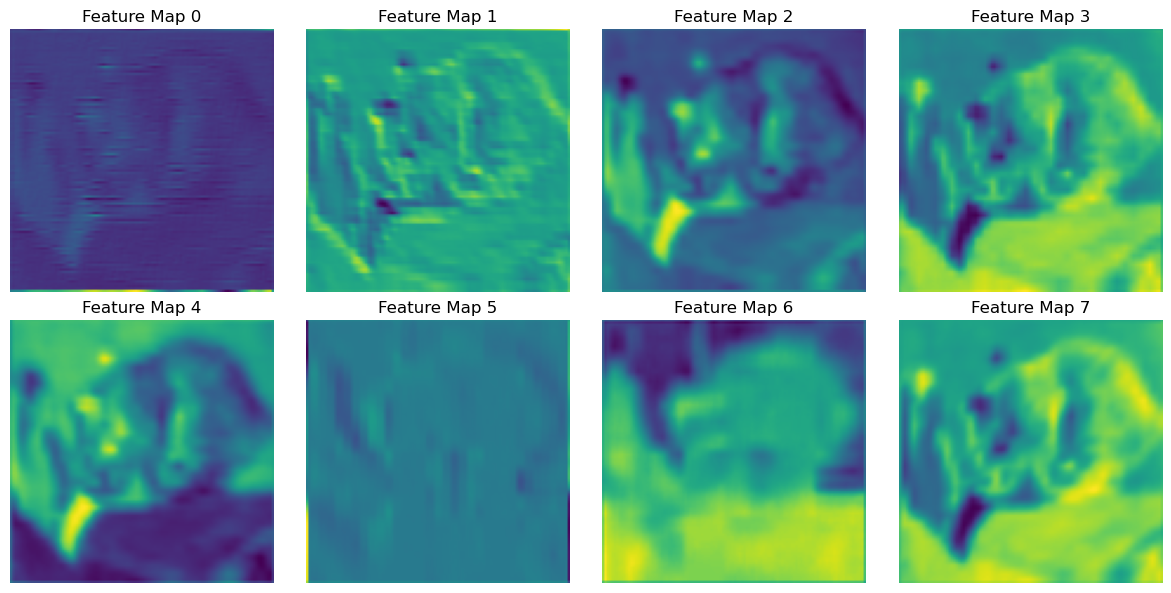

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

# 1. Load sample image from CIFAR-10
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

dataset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)
sample_img, label = dataset[0]  # Get the first image and its label
input_tensor = sample_img.unsqueeze(0)  # Add batch dimension [1, 3, 224, 224]

# 2. Load pretrained ResNet18
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')

model.eval()

# 3. Hook into the first convolution layer to extract feature maps
feature_maps = []

def hook_fn(module, input, output):
    feature_maps.append(output.detach())

hook = model.conv1.register_forward_hook(hook_fn)

# 4. Forward pass
_ = model(input_tensor)

# 5. Visualize first 8 feature maps
activation = feature_maps[0].squeeze(0)  # Shape: [64, H, W]
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(activation[i].cpu(), cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Feature Map {i}')
plt.tight_layout()
plt.show()

# 6. Cleanup
hook.remove()